<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 16


In [1]:
import sys
sys.path.append("../")

In [2]:
from itertools import cycle, islice
import numpy as np

In [3]:
from sklearn import mixture
from sklearn import metrics
from pomegranate import *

In [4]:
from scipy.stats import kde
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [5]:
from helpers import read_configuration_file, INFO, WARNING
from train import main
from train import load_regions
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [6]:
sns.set(color_codes=True)

Apply ```HMM_Model_3_GMM_TUF_INCREASE_DUP_NO_WGA.json``` in region ```region_0_REGION_2_5S.txt``` [20000000-40000000]

In [7]:
# load the configuration
configuration = read_configuration_file("../config.json")
hmm_config = configuration["HMM"]

Orphan state HMM_Model-start removed due to no edges                             leading to it
Orphan state HMM_Model-end removed due to no edges                             leading to it


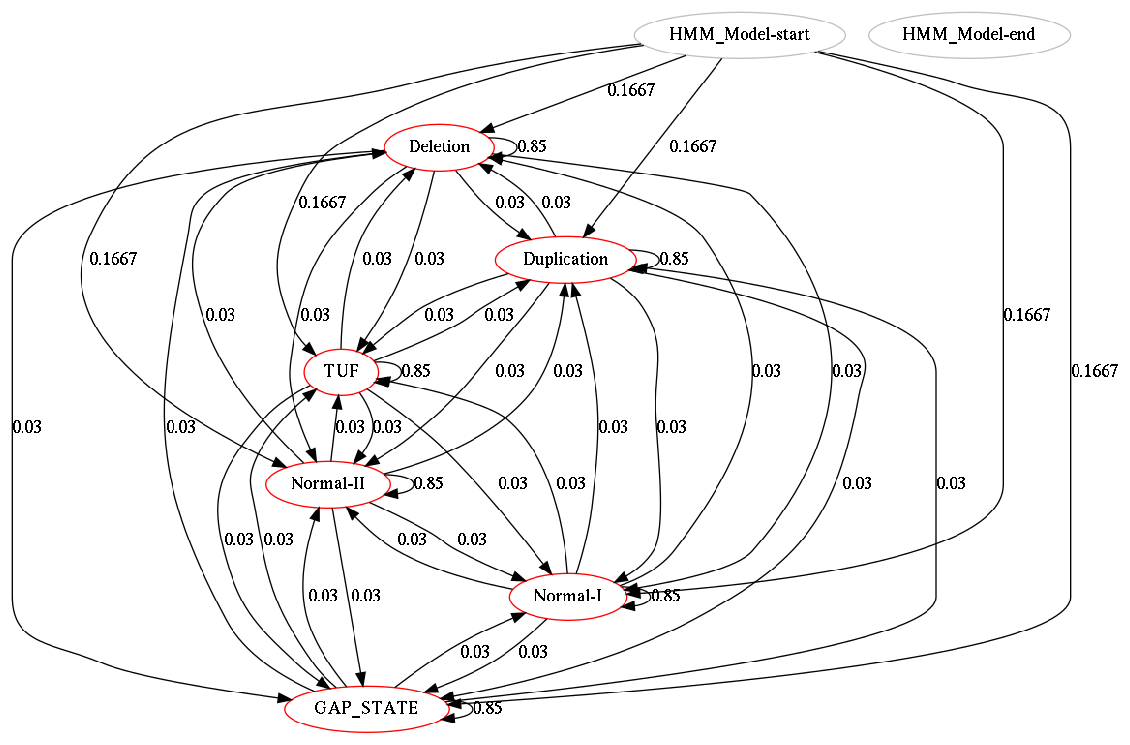

In [9]:
hmm_filename = "HMM_Model_3_GMM_TUF_INCREASE_DUP_NO_WGA.json"
hmm_model = build_hmm(hmm_file=hmm_filename)

# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm_model.plot()
plt.show()

In [10]:
# load the region we want to use for prediction
region_name = "region_0_REGION_2_5S.txt"
region_file = "/home/david/Desktop/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

INFO: Loading region from file: /home/david/Desktop/region_0_REGION_2_5S.txt
Sequence length:  199492


In [11]:
observations = []
for i in range(len(sequence)):
    observations.append(sequence[i][0])

print("Observation length: ", len(observations))

time_start = time.perf_counter()
viterbi_path = hmm_model.viterbi(observations)
time_end = time.perf_counter()
print("Done. Execution time"
          " {0} secs".format(time_end - time_start))
print("Log-probability of ML Viterbi path: ", viterbi_path[0])

# for each item in the sequence
# cache the index and state predicted
sequence_viterbi_state = []

if viterbi_path[1] is not None:
        print("Viterbi path length: ", len(viterbi_path[1]))
        filename="viterbi_path_TUF_GMM_INCREASE_NO_WGA_" + region_name 
        counter = 0
        with open(filename, 'w') as f:
            f.write(str(len(viterbi_path[1])-1) + "\n")
            for item in range(len(sequence)):

                if sequence[item][0] == (-999.0, -999.0):
                    counter += 1

                f.write(str(item)+ ":" + str(sequence[item][1]) + ":" + str(sequence[item][0]) + ":" + viterbi_path[1][item+1][1].name + "\n")
                sequence_viterbi_state.append((item, viterbi_path[1][item+1][1].name))
                
                #print("sequnce item: {0} state {1}".format(sequence[item], viterbi_path[1][item+1][1].name))
        print("There should be {0} gaps".format(counter))
else:
        print("Viterbi path is impossible for the given sequence")

Observation length:  199492
Done. Execution time 0.7982735519999551 secs
Log-probability of ML Viterbi path:  -1355164.2235948346
Viterbi path length:  199493
There should be 17 gaps


In [12]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  199475
Encountered gaps:  17


In [13]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0}

# collect counters for error statistics
for i, obs in enumerate(observations):
    
    # what dows the Viterbi path says
    viterbi_state = sequence_viterbi_state[i][1]
    if obs == (-999.0, -999.0):
        
        # if we predict that increase the success 
        # otherwise increase errors
        if viterbi_state == 'GAP_STATE':
            states_counter[viterbi_state] += 1
        else:
            states_counter["GAP_STATE_INCORRECT"] += 1
    else:
        states_counter[viterbi_state] += 1   
        
print(states_counter)

{'Duplication': 75, 'Normal-I': 93092, 'Normal-II': 102721, 'Deletion': 713, 'Single-Deletion': 0, 'TUF': 2874, 'GAP_STATE': 17, 'GAP_STATE_INCORRECT': 0}


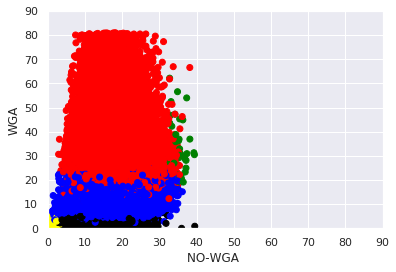

HMM labels color:  {'blue': [1, 93092], 'red': [2, 102721], 'green': [0, 75], 'black': [5, 2874], 'yellow': [3, 713]}


In [14]:
hmm_labels = []
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5}
for i, obs in enumerate(observations):
        if obs != (-999.0, -999.0):
            viterbi_state = sequence_viterbi_state[i][1]
            hmm_labels.append(hmm_states_to_labels[viterbi_state])


colors = np.array(['green', 'blue', 'red', 'yellow', 'pink', 'black'])
colors = colors[hmm_labels]
       
plt.scatter(no_wga_obs, wga_obs,  color=colors)
        
        
plt.xlabel("NO-WGA ")
plt.ylabel("WGA")
plt.xlim(0.0, 90.0)
plt.ylim(0.0, 90.0)
plt.show()

color_comp_assoc_hmm = {}
for label, color in zip(hmm_labels, colors):
    if color in color_comp_assoc_hmm.keys():
        assert color_comp_assoc_hmm[color][0] == label
        color_comp_assoc_hmm[color][1] += 1
    else:
        color_comp_assoc_hmm[color] = [label, 1]
        
        
print("HMM labels color: ", color_comp_assoc_hmm)

State:  Duplication
Length: 75


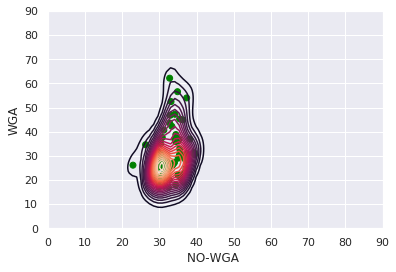

State:  Normal-I
Length: 93092


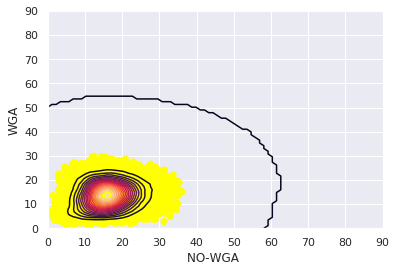

State:  Normal-II
Length: 102721


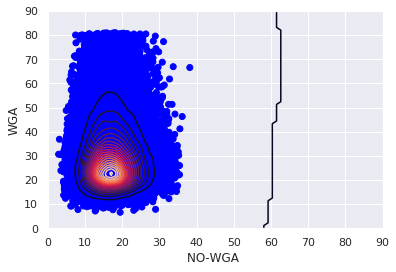

State:  Deletion
Length: 713


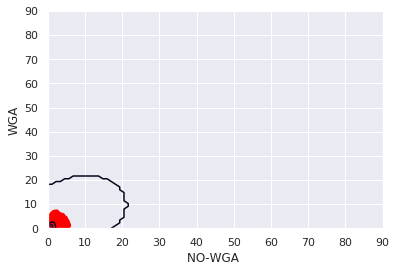

State:  Single-Deletion
For state: Single-Deletion could not plot empty observations
State:  TUF
Length: 2874


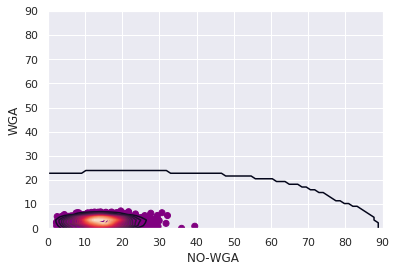

In [15]:
for label in hmm_states_to_labels:
    
    print("State: ", label)
    label_idx = hmm_states_to_labels[label]
    
    state_labels = []
    
    state_no_wga_obs = []
    state_wga_obs = []
    for i, item in enumerate(hmm_labels):
        if item == label_idx:
            state_labels.append(label_idx)
            state_no_wga_obs.append(no_wga_obs[i])
            state_wga_obs.append(wga_obs[i])
       
    
    colors = np.array(['green', 'yellow', 'blue', 'red', 'pink', 'purple'])
    
    if len(state_no_wga_obs) != 0:
        
        print("Length: {0}".format(len(state_no_wga_obs)))
       
        
        colors = colors[state_labels]
    
        # plot the observations
        plt.scatter(state_no_wga_obs, state_wga_obs,  color=colors)
        
        kernel= kde.gaussian_kde(np.vstack([state_no_wga_obs, state_wga_obs]))
        #xi, yi = np.mgrid[min(state_no_wga_obs):max(state_no_wga_obs):nbins*1j, 
        #                       min(state_wga_obs):max(state_wga_obs):nbins*1j]
        
        xi, yi = np.mgrid[min([0.0]):max([90.0]):nbins*1j, 
                               min([0.0]):max([90.0]):nbins*1j]

        zi = kernel(np.vstack([xi.flatten(), yi.flatten()]))
        plt.contour(xi, yi, zi.reshape(xi.shape), 24 )

        plt.xlabel("NO-WGA ")
        plt.ylabel("WGA")
        
        if label == "Duplication":
            plt.xlim(0.0, 90.0)
            plt.ylim(0.0, 90.0)
        if label == "Normal-I": 
            plt.xlim(0.0, 90.0)
            plt.ylim(0.0, 90.0)
        if label == "Normal-II":
            plt.xlim(0.0, 90.0)
            plt.ylim(0.0, 90.0)
        if label == "Deletion":
            plt.xlim(0.0, 90.0)
            plt.ylim(0.0, 90.0)
        if label == "TUF":
            plt.xlim(0.0, 90.0)
            plt.ylim(0.0, 90.0)
            
        plt.show()
    else:
        print("For state: {0} could not plot empty observations".format(label))

In [56]:
from IPython.core.debugger import set_trace
obs_state = {}

for state in hmm_states_to_labels:
    obs_state[state] = []

for i, obs in enumerate(observations):
        if obs != (-999.0, -999.0):
            viterbi_state = sequence_viterbi_state[i][1]
            obs_state[viterbi_state].append(obs)
            
states = hmm_model.states

state_vars = {}

for state in states:
    
    
    if state.name in hmm_states_to_labels:
        
        print("State: ", state.name)
    
        if state.distribution.name == "MultivariateGaussianDistribution":
            print(state.distribution.parameters)
            
            state_vars[state.name] = state.distribution.parameters
            
        elif state.name == 'TUF':
            
            state_vars[state.name] = {}
           
            for comp in state.distribution.distributions:
                state_vars[state.name]["comp1"] = comp.parameters
                print(comp.parameters)
            weights = state.distribution.weights
            state_vars[state.name]["weights"] = [0.66, 0.3400000000000001] 
            print("Weights: ", [0.66, 0.3400000000000001])

#print(states)
    

State:  Deletion
[[0.970706158337221, 0.9584905794190409], [[1.1048471845652486, 0.0], [0.0, 1.1940801686626292]]]
State:  Duplication
[[24.28362902767221, 45.0], [[39.472612749573955, 0.0], [0.0, 71.53900035698678]]]
State:  Normal-I
[[13.75126220265661, 16.65624521497922], [[19.020809219473197, 0.0], [0.0, 31.48580311378834]]]
State:  Normal-II
[[23.31434958333479, 19.641851278128932], [[52.49001016609736, 0.0], [0.0, 19.605475007467025]]]
State:  TUF
[[1.7345500646576917, 14.220263675791802], [[1.9261202863037925, 0.0], [0.0, 15.656083256828397]]]
[[1.7345500646576917, 40.0], [[1.9261202863037925, 0.0], [0.0, 15.656083256828397]]]
Weights:  [0.66, 0.3400000000000001]


Number of observations for state Duplication is 75


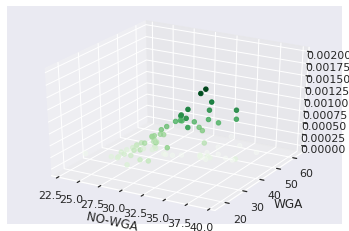

In [99]:
from mpl_toolkits import mplot3d

# for each state find its min/max
for state in obs_state:
    #min_ = min(obs_state[state])
    #max_ = max(obs_state[state])
    
    if state == 'Duplication':
        
        #mu_no_wga = means[idx][0]
        #mu_wga = means[idx][1]
        #mu = np.array([24.28363165, 45.0])
        #print("State means: ", means[idx])
        #cov = covariances[idx]
        #print("State covariance: ", cov)
        #cov = np.array([[cov[1], 0.0], [0.0, cov[0]]])
        
        params = state_vars[state]
        state_dist = MultivariateGaussianDistribution(means=np.array(params[0]),
                                                      covariance=np.array(params[1]))
        
        print("Number of observations for state {0} is {1}".format(state, len(obs_state[state])))
        
        zi = []
        
        state_wga_obs = [ item[0] for item in obs_state[state]]
        state_no_wga_obs = [ item[1] for item in obs_state[state]]
        
        #for obs_no_wga in state_no_wga_obs:
        #    for obs_wga in state_wga_obs:
        #        zi.append(state_dist.probability((obs_wga, obs_no_wga)))
                
        for obs in  obs_state[state]:
            zi.append(state_dist.probability(obs))
        

        fig = plt.figure()
        ax = plt.axes(projection='3d')


        #ax.plot3D(state_no_wga_obs, state_wga_obs, zi, 'gray')
        ax.scatter3D(state_no_wga_obs, state_wga_obs, zi, c=zi, cmap='Greens');
        
        # plot the observations
        #plt.scatter(state_no_wga_obs, state_wga_obs,  color='red')
        
        
        #xi, yi = np.mgrid[min([0.0]):max([90.0]):nbins*1j, 
        #                       min([0.0]):max([90.0]):nbins*1j]

        #xi, yi = np.meshgrid(np.array(state_no_wga_obs), np.array(state_wga_obs))
        
        #print(xi)
        #print("Shape xi ", xi.shape)
        #print("Shape yi ", yi.shape)
        #zi = np.array(zi).reshape(75, 75)
        #print("Shape zi ", zi.shape)
        #plt.contour(xi, yi, zi, 1, colors='black' )
        
        plt.xlabel("NO-WGA ")
        plt.ylabel("WGA")

(50,)
(40,)
(40, 50)
(40, 50)
(40, 50)


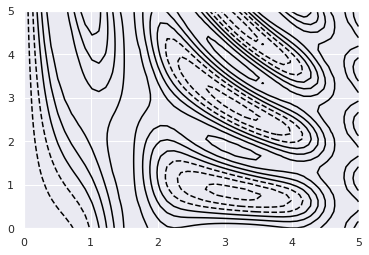

In [76]:


def f(x, y):
    return np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)



x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 40)

print(x.shape)
print(y.shape)

X, Y = np.meshgrid(x, y)

print(X.shape)
print(Y.shape)


Z = f(X, Y)

print(Z.shape)

plt.contour(X, Y, Z, colors='black');
